{N2pt, N3pt}={3,3} state fit: 12 parameters

Flow tau =  0.0
Points included for fit:  43
DOF =  31
chi2dof 1.2367(5006) 

Akaike Information Criterion (AIC) = 62.33701520680088
Corrected AIC (AICc) = 69.7655866353723 

  M0 = 0.4761(0085) = 0.47610791505 ± 0.00847270104
  A0^2 = 5.66(47)e-10 = 0.00000000057 ± 0.00000000005
  M1 = 0.8478(0123) = 0.84781287086 ± 0.01225196021
  A1^2 = 2.53(137)e-10 = 0.00000000025 ± 0.00000000014
 O00 = 1.4225(1077) = 1.42248536582 ± 0.10768942793
 O01 = -0.0997(0832) = -0.09972321285 ± 0.08315023084
 O11 = -2.8147(70295) = -2.81472675909 ± 7.02950214249
  M2 = 2.4032(7784) = 2.40315911944 ± 0.77844916116
  A2 = 7.81(813)e-5 = 0.00007808313 ± 0.00008125815
 O02 = 0.0390(0711) = 0.03895035716 ± 0.07113338503
 O12 = -0.9356(13325) = -0.93564432929 ± 1.33246304213
 O22 = 0.3484(0045) = 0.34835321442 ± 0.00446999339
A1^2 / A0^2 = 2.2404(13846) = 2.240381 ± 1.384576

 0.4761(0085) & 0.8478(0123) & 5.66(47)e-10 & 2.53(137)e-10 & 2.2404(13846) & 1.2367(5006) &

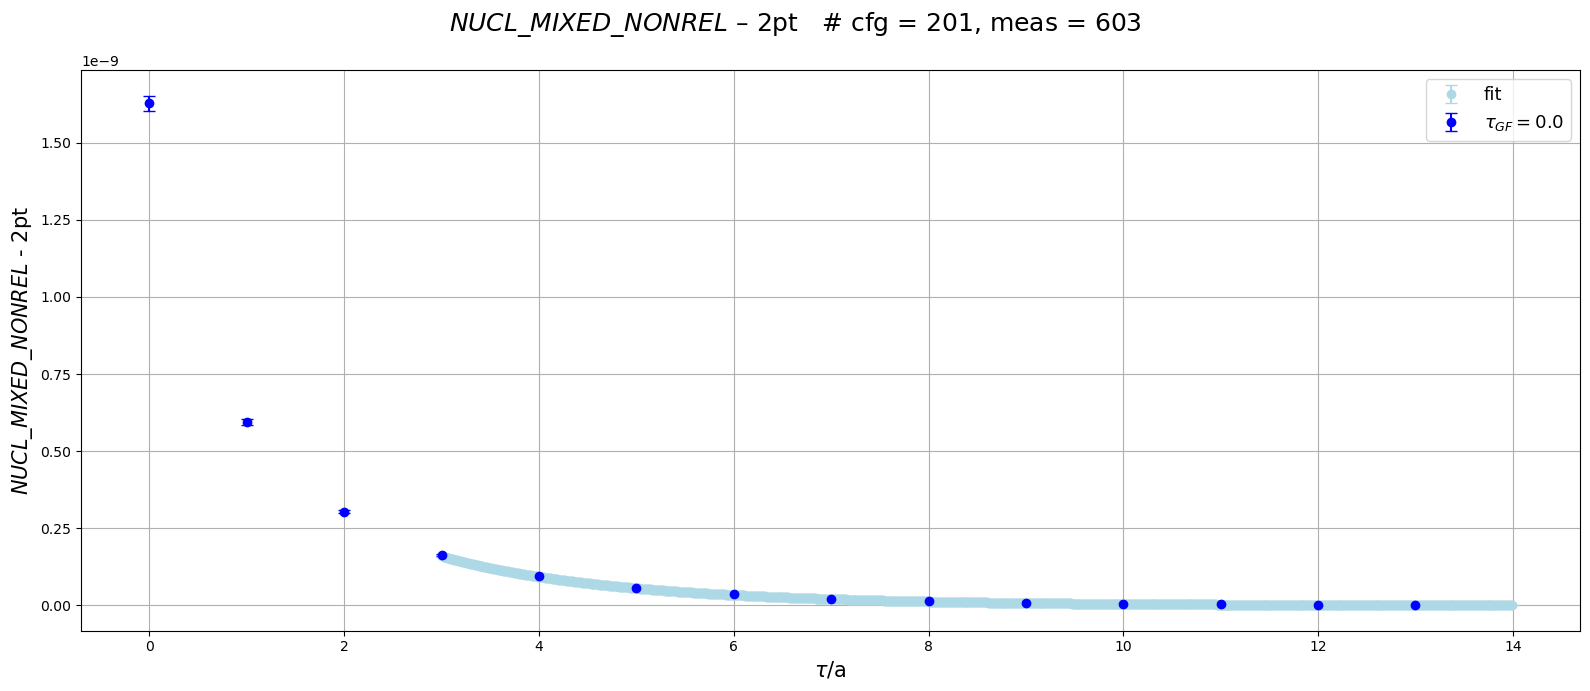

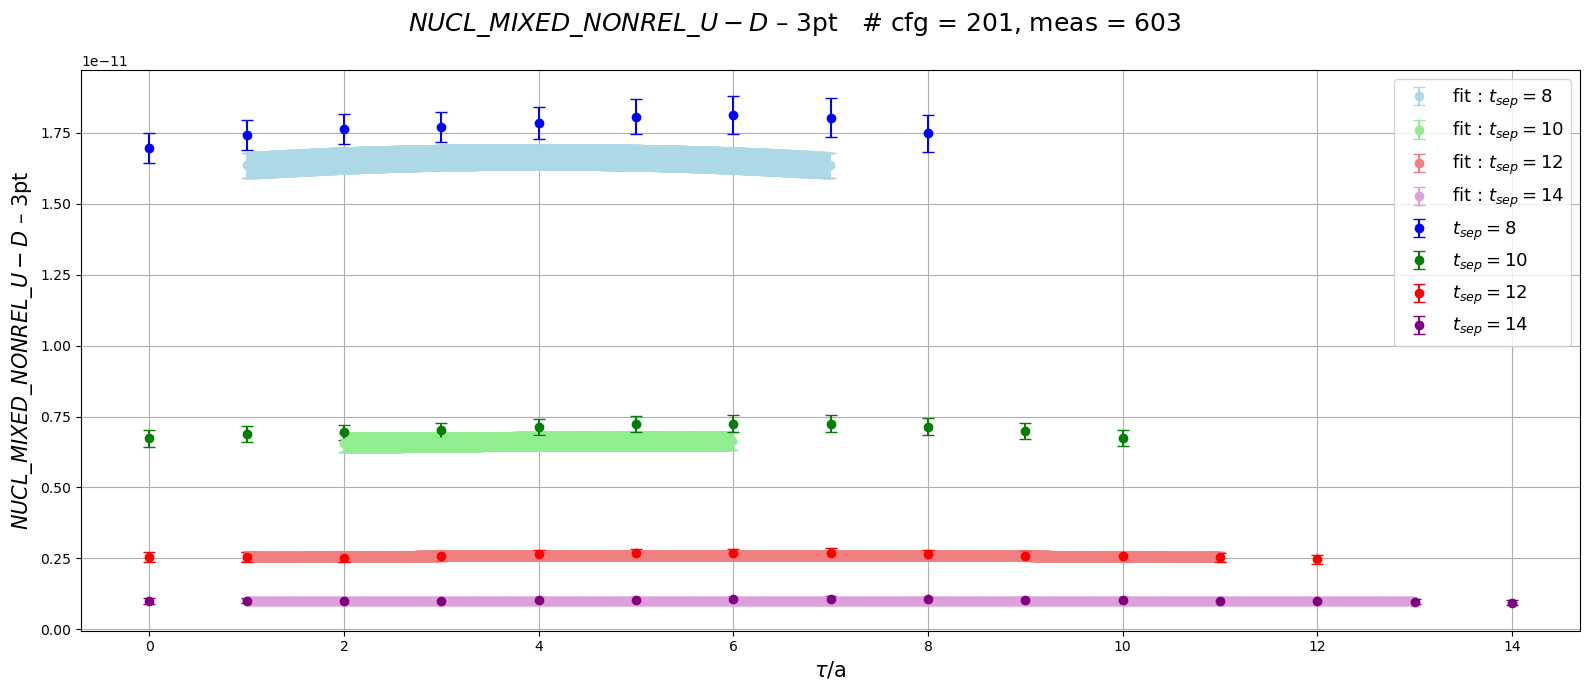

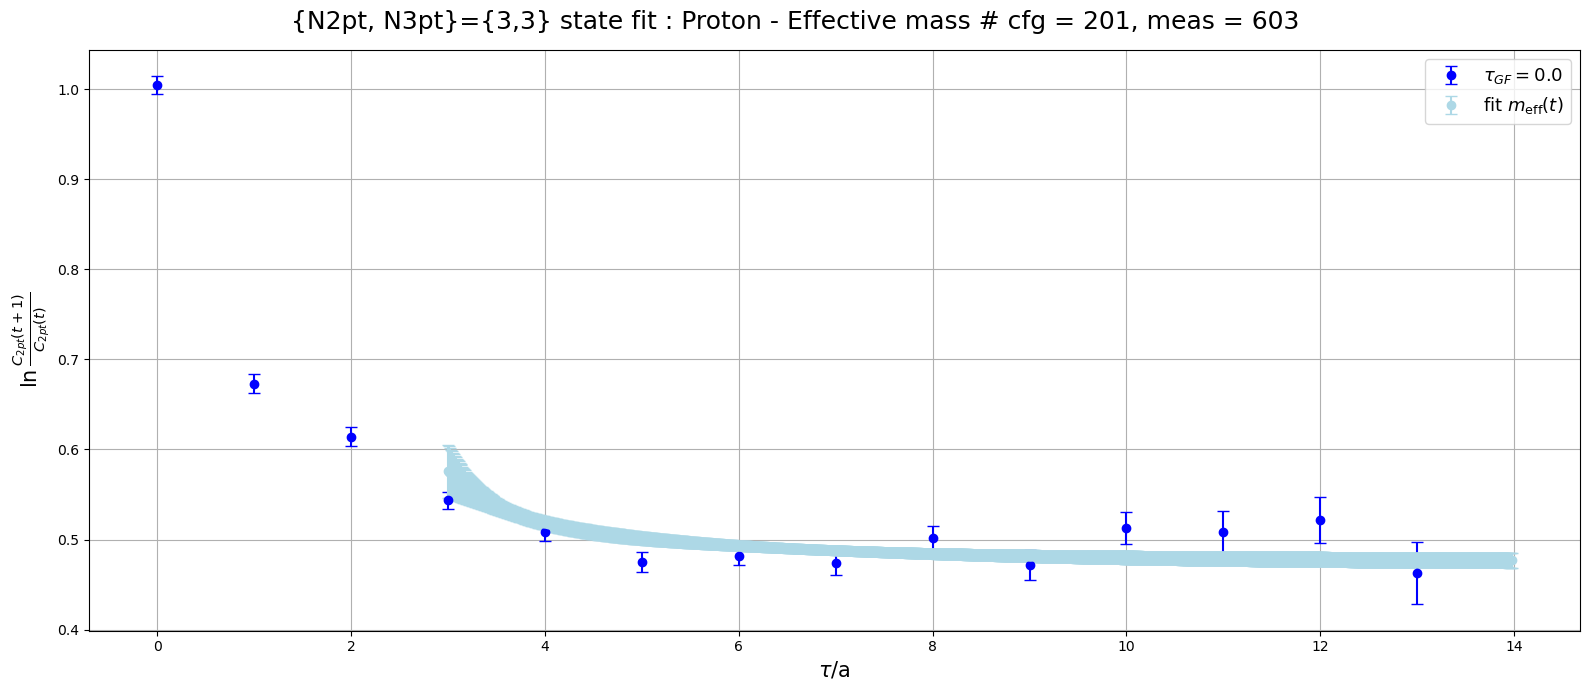

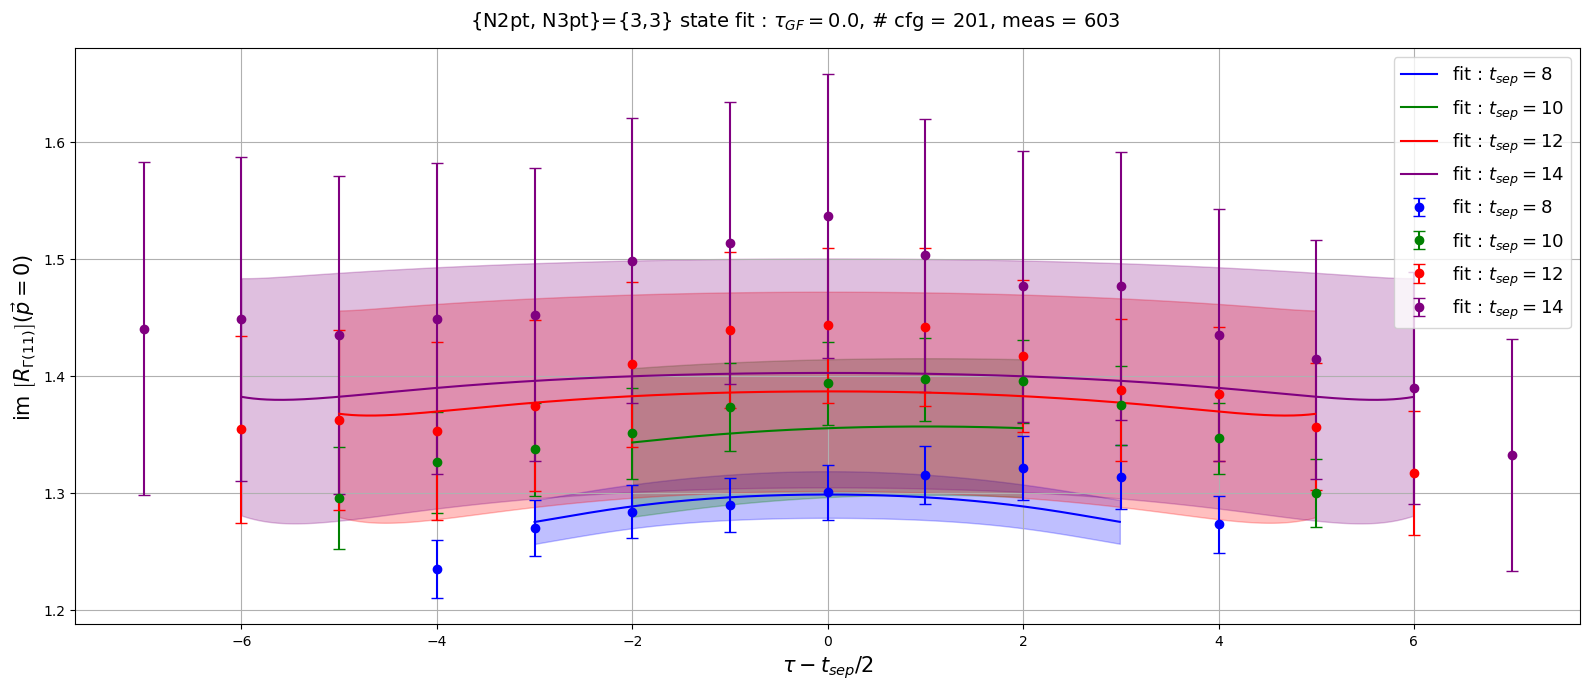

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gvar as gv
import lsqfit

cfglist = (
    pd.read_csv("/pscratch/sd/h/hari_8/production_nEDM_LANL/config_numbers.txt", header=None, dtype=str)  # 1-column DataFrame
      .squeeze("columns")                                      # -> Series
      .tolist()                                                # -> Python list
)


def fmt_err(mean, err):
    # switch to scientific if very small/big
    if mean and (abs(mean) < 1e-3 or abs(mean) >= 1e3):
        m_str = f"{mean:.2e}"           # e.g. "2.86e-08"
        mant, exp = m_str.split("e")
        ndec = len(mant.split(".")[1])  # digits in mantissa
        err_int = int(round(err / 10**int(exp) * 10**ndec))
        return f"{mant}({err_int})e{int(exp)}"
    else:
        ndec = 4                        # choose 4 decimal places
        m_str = f"{mean:.{ndec}f}"      # e.g. "0.4721"
        err_int = int(round(err * 10**ndec))
        return f"{m_str}({err_int:0{ndec}d})"
        
def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set

def give_jk_3pt(Num, Gn, WFt, snk_time, pt2_cfg):
    # Load 3pt data
    U_pt3_cfg = []
    D_pt3_cfg = []
    for j, cfg in enumerate(cfglist):
        U_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_NUCL_U_MIXED_NONREL3pt_t{snk_time}_{cfg}.h5"
    
        with h5py.File(U_file_path, "r") as h5_file: 
            U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
            U_observable_cfgb = h5_file[U_path_to_observable_cfgb]
            U_values = U_observable_cfgb[Num][()]

        #t0x0y0z0_t21x10y10z10_t42x20y20z20
        U_pt3_data = np.array(U_values)
        U_pt3_data1 = U_pt3_data[0:(0+(snk_time+1))]
        U_pt3_data2 = U_pt3_data[21:(21+(snk_time+1))]
        U_pt3_data3 = U_pt3_data[42:(42+(snk_time+1))]
        U_pt3_cfg.append((U_pt3_data1+U_pt3_data2+U_pt3_data3)/3)
    
        D_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_NUCL_D_MIXED_NONREL3pt_t{snk_time}_{cfg}.h5"
    
        with h5py.File(D_file_path, "r") as h5_file: 
            D_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
            D_observable_cfgb = h5_file[D_path_to_observable_cfgb]
            D_values = D_observable_cfgb[Num][()]
    
        D_pt3_data = np.array(D_values)
        D_pt3_data1 = D_pt3_data[0:(0+(snk_time+1))]
        D_pt3_data2 = D_pt3_data[21:(21+(snk_time+1))]
        D_pt3_data3 = D_pt3_data[42:(42+(snk_time+1))]
        D_pt3_cfg.append((D_pt3_data1+D_pt3_data2+D_pt3_data3)/3)
    # Compute jackknife
    pt2_jackknifeset = Jackknifeset([pt2_cfg[i][(snk_time)] for i in range(len(pt2_cfg))])
    pt3bypt2_JK_value = []
    pt3bypt2_JK_err = []
    pt3_JK_value = []
    pt3_JK_err = []
    pt3_jackk_set = []
    for tau in range(snk_time+1):
        U_tau_Jackknifeset = Jackknifeset([U_pt3_cfg[i][tau] for i in range(len(U_pt3_cfg))])
        D_tau_Jackknifeset = Jackknifeset([D_pt3_cfg[i][tau] for i in range(len(D_pt3_cfg))])
        UD = (np.array(U_tau_Jackknifeset) - np.array(D_tau_Jackknifeset))
        pt3_JK_value_err = Jackknife(UD)
        UDby2pt = (np.array(U_tau_Jackknifeset) - np.array(D_tau_Jackknifeset)) / np.array(pt2_jackknifeset)
        pt3bypt2_JK_value_err = Jackknife(UDby2pt)
        
        pt3_jackk_set.append(UD)
        pt3_JK_value.append(pt3_JK_value_err[0])
        pt3_JK_err.append(pt3_JK_value_err[1])
        pt3bypt2_JK_value.append(pt3bypt2_JK_value_err[0])
        pt3bypt2_JK_err.append(pt3bypt2_JK_value_err[1])
    return(pt3_jackk_set, pt3_JK_value, pt3_JK_err, pt3bypt2_JK_value, pt3bypt2_JK_err)

     
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))

def C2_fit(tau, M0, A0, M1, A1, M2, A2):
    return A0**2*np.exp(-M0*tau) + A1**2*np.exp(-M1*tau) + A2**2*np.exp(-M2*tau)



def C3_fit(tau, M0, A0, M1, A1, O00, O01, O11, M2, A2, O02, O12, O22, snk_time):
    exp0 = np.exp(-M0*(snk_time - tau) - M1*tau)
    exp1 = np.exp(-M1*(snk_time - tau) - M0*tau)
    g22 = A2*A2*O22 * np.exp(-M2*snk_time)
    g02 = A0*A2*O02 * ( np.exp(-M0*(snk_time-tau))*np.exp(-M2*tau)
                      + np.exp(-M2*(snk_time-tau))*np.exp(-M0*tau) )
    g12 = A1*A2*O12 * ( np.exp(-M1*(snk_time-tau))*np.exp(-M2*tau)
                      + np.exp(-M2*(snk_time-tau))*np.exp(-M1*tau) )

    return (A0*A0*O00 * np.exp(-M0*snk_time) + A0*A1*O01 * (exp0 + exp1) + A1*A1*O11 * np.exp(-M1*snk_time) + g02 + g12 + g22)

def fcn(x, p):
    # x is a dict: x['c2'], x['c3']
    t   = x['c2']
    taut8 = x['c3t8']
    taut10 = x['c3t10']
    taut12 = x['c3t12']
    taut14 = x['c3t14']
    M0, A0, M1, A1, O00, O01, O11, M2, A2, O02, O12, O22 = (
        p['M0'], p['A0'], p['M1'], p['A1'],
        p['O00'], p['O01'], p['O11'], p['M2'], p['A2'], p['O02'], p['O12'], p['O22']
    )
    C2 = A0**2 * np.exp(-M0*t) + A1**2 * np.exp(-M1*t)+ A2**2 * np.exp(-M2*t)

    C3t8 = C3_fit(taut8, M0, A0, M1, A1, O00, O01, O11, M2, A2, O02, O12, O22, snk_time = 8)
    C3t10 = C3_fit(taut10, M0, A0, M1, A1, O00, O01, O11, M2, A2, O02, O12, O22, snk_time = 10)
    C3t12 = C3_fit(taut12, M0, A0, M1, A1, O00, O01, O11, M2, A2, O02, O12, O22, snk_time = 12)
    C3t14 = C3_fit(taut14, M0, A0, M1, A1, O00, O01, O11, M2, A2, O02, O12, O22, snk_time = 14)

    return {'c2':C2, 'c3t8':C3t8, 'c3t10':C3t10, 'c3t12':C3t12, 'c3t14':C3t14}

# very loose priors
paramas = 12
prior = {
         'M0': gv.gvar(0.4721,    5*0.0025),
         'A0': gv.gvar(1.691e-4,  5*2.7e-5),
         'M1': gv.gvar(0.8510,    5*0.0028),
         'A1': gv.gvar(1.847e-4,  5*3.5e-5),
         'O00': gv.gvar(1.349,    5*0.019),   # from 1.349(19)
         'O01': gv.gvar(-0.130,   5*0.020),   # from –0.130(20)
         'O11': gv.gvar(0.600,    5*0.700),   # from 0.6(0.7)
         'M2': gv.gvar(4*0.8510, 5*0.2),
         'A2': gv.gvar(1.847e-4/4, 5*1e-5),
         'O02': gv.gvar(1.349,    10*0.019),
         'O12': gv.gvar(1.349,    10*0.019),
         'O22': gv.gvar(1.349,    10*0.019),
       }



def plot_all_flows(Gn, Num, cfglist, fit_ti_c2, fit_tf_c2, fit_ti_c3_t8, fit_tf_c3_t8, fit_ti_c3_t10, fit_tf_c3_t10, fit_ti_c3_t12, fit_tf_c3_t12, fit_ti_c3_t14, fit_tf_c3_t14):
    #print("C2 Fit from t = ", fit_ti_c2 ," to ", fit_tf_c2-1,"\n")
    #print("C3 Fit from t = ", fit_ti_c3 ," to ", fit_tf_c3-1,"\n")
    #dofpluspara = (fit_tf_c2-fit_ti_c2)+(fit_tf_c3_t10-fit_ti_c3_t10)+1
    
    print(f"{{N2pt, N3pt}}={{3,3}} state fit: {paramas} parameters\n")
    
    flow_times = ["0p0"]#,"8p0", "12p5", "18p0"]
    tau_GF = [0]#, 8.0, 12.5, 18]
    colors = ['blue', 'green', 'red', 'purple']
    colorsfit = ['lightblue', 'lightgreen', 'lightcoral', 'plum']
    markers = ['o', 's', '^', 'D']

    fig1, ax1 = plt.subplots(figsize=(16,7))
    fig2, ax2 = plt.subplots(figsize=(16,7))
    fig3, ax3 = plt.subplots(figsize=(16,7))
    fig4, ax4 = plt.subplots(figsize=(16,7))

    for i, WFt in enumerate(flow_times):
        print("Flow tau = ", np.sqrt(8*tau_GF[i]))
        # Load 3pt data
        U_pt3_cfg = []
        D_pt3_cfg = []
        pt2_cfg = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1

            # Load 2pt data
            
            pt2_file_path = "/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/hadspec.h5"
        
            with h5py.File(pt2_file_path, "r") as h5_file: 
                pt2_path_to_observable_cfgb = f"//proton.D-2389.DG7_6.DG7_6.SS/{WFt}_had_{cfg}"
                pt2_observable_cfgb = h5_file[pt2_path_to_observable_cfgb]
                pt2_values = pt2_observable_cfgb["re"][()]
            pt2_data = np.array(pt2_values)
            pt2_data1 = pt2_data[0:(0+(14+1))]
            pt2_data2 = pt2_data[21:(21+(14+1))]
            pt2_data3 = pt2_data[42:(42+(14+1))]
            pt2_cfg.append((pt2_data1+pt2_data2+pt2_data3)/3)

        # Compute jackknife
        pt2_JK_value = []
        pt2_JK_err = []
        pt2_jackk_set = []
        pt22ffmass_JK_value = []
        pt22ffmass_JK_err = []
        for tau in range(14):
            pt2_tau_Jackknifeset = Jackknifeset([pt2_cfg[i][tau] for i in range(len(pt2_cfg))])
            pt2_tau_1_Jackknifeset = Jackknifeset([pt2_cfg[i][tau+1] for i in range(len(pt2_cfg))])
            pt2ffmass_tau_Jackknifeset = np.log(pt2_tau_Jackknifeset)-np.log(pt2_tau_1_Jackknifeset)
            pt22ffmass_JK_value.append(Jackknife(np.array(pt2ffmass_tau_Jackknifeset))[0])
            pt22ffmass_JK_err.append(Jackknife(np.array(pt2ffmass_tau_Jackknifeset))[1])
            
            pt2_JK_value_err = Jackknife(np.array(pt2_tau_Jackknifeset))
            pt2_jackk_set.append(pt2_tau_Jackknifeset)
            pt2_JK_value.append(pt2_JK_value_err[0])
            pt2_JK_err.append(pt2_JK_value_err[1])

         
        

  
            
        pt3_jackk_set_t8, pt3_JK_value_t8, pt3_JK_err_t8, pt3bypt2_JK_value_t8, pt3bypt2_JK_err_t8 = give_jk_3pt(Num, Gn, WFt, 8, pt2_cfg)
        pt3_jackk_set_t10, pt3_JK_value_t10, pt3_JK_err_t10, pt3bypt2_JK_value_t10, pt3bypt2_JK_err_t10 = give_jk_3pt(Num, Gn, WFt, 10, pt2_cfg)
        pt3_jackk_set_t12, pt3_JK_value_t12, pt3_JK_err_t12, pt3bypt2_JK_value_t12, pt3bypt2_JK_err_t12 = give_jk_3pt(Num, Gn, WFt, 12, pt2_cfg)
        pt3_jackk_set_t14, pt3_JK_value_t14, pt3_JK_err_t14, pt3bypt2_JK_value_t14, pt3bypt2_JK_err_t14 = give_jk_3pt(Num, Gn, WFt, 14, pt2_cfg)
        
        n2 = fit_tf_c2 - fit_ti_c2
        n3_t8 = fit_tf_c3_t8 - fit_ti_c3_t8
        n3_t10 = fit_tf_c3_t10 - fit_ti_c3_t10
        n3_t12 = fit_tf_c3_t12 - fit_ti_c3_t12
        n3_t14 = fit_tf_c3_t14 - fit_ti_c3_t14
        n_data = n2 + n3_t8 + n3_t10 + n3_t12 + n3_t14
        dof    = n_data - paramas
        print("Points included for fit: ", n_data )
        print("DOF = ", dof)
    
        data_samples = np.zeros((nocfg, n2+n3_t8+n3_t10+n3_t12+n3_t14))
        for jk in range(nocfg):
            data_samples[jk, 0:n2]   = [pt2_jackk_set[t][jk]
                                       for t in range(fit_ti_c2, fit_tf_c2)]
            data_samples[jk, n2:n2+n3_t8]   = [pt3_jackk_set_t8[t][jk] for t in range(fit_ti_c3_t8, fit_tf_c3_t8)]
            data_samples[jk, n2+n3_t8:n2+n3_t8+n3_t10]   = [pt3_jackk_set_t10[t][jk] for t in range(fit_ti_c3_t10, fit_tf_c3_t10)]
            data_samples[jk, n2+n3_t8+n3_t10:n2+n3_t8+n3_t10+n3_t12]   = [pt3_jackk_set_t12[t][jk] for t in range(fit_ti_c3_t12, fit_tf_c3_t12)]
            data_samples[jk, n2+n3_t8+n3_t10+n3_t12:n2+n3_t8+n3_t10+n3_t12+n3_t14]   = [pt3_jackk_set_t14[t][jk] for t in range(fit_ti_c3_t14, fit_tf_c3_t14)]
            
    
        # jackknife covariance:
        mean_vec = data_samples.mean(axis=0)
        dev = data_samples - mean_vec
        cov = (nocfg-1)/nocfg * (dev.T @ dev)
        x_dict = {'c2': np.arange(fit_ti_c2, fit_tf_c2),'c3t8': np.arange(fit_ti_c3_t8, fit_tf_c3_t8),'c3t10': np.arange(fit_ti_c3_t10, fit_tf_c3_t10),'c3t12': np.arange(fit_ti_c3_t12, fit_tf_c3_t12),'c3t14': np.arange(fit_ti_c3_t14, fit_tf_c3_t14)}
        param_names = ['M0','A0','M1','A1','O00','O01','O11','M2','A2', 'O02', 'O12', 'O22']
        fits_jk = np.zeros((nocfg, len(param_names)))

        chi2perdofjk = []
        chi2jk = []
        plotfit_c2 = []
        plotfit_c3_t8 = []
        plotfit_c3_t10 = []
        plotfit_c3_t12 = []
        plotfit_c3_t14 = []
        plotfit_c3byc2_t8 = []
        plotfit_c3byc2_t10 = []
        plotfit_c3byc2_t12 = []
        plotfit_c3byc2_t14 = []
        t_fine_c2 = np.arange(fit_ti_c2, fit_tf_c2, 0.01)
        plotfit_effm = []
        for jk in range(nocfg):
            # build a gvar y-vector for this jackknife sample
            y_jk = gv.gvar(data_samples[jk], cov)
            y_dict_jk = {'c2': y_jk[0:n2], 'c3t8': y_jk[n2:n2+n3_t8], 'c3t10': y_jk[n2+n3_t8:n2+n3_t8+n3_t10], 'c3t12': y_jk[n2+n3_t8+n3_t10:n2+n3_t8+n3_t10+n3_t12], 'c3t14': y_jk[n2+n3_t8+n3_t10+n3_t12:n2+n3_t8+n3_t10+n3_t12+n3_t14]}

            current_prior = {
              'M0':  gv.gvar(0.4721,    5*0.0025* np.random.uniform(0.8, 1.3)),
               'A0':  gv.gvar(1.691e-4,  5*2.7e-5* np.random.uniform(0.8, 1.3)),
               'M1':  gv.gvar(0.8510,    5*0.0028* np.random.uniform(0.8, 1.3)),
               'A1':  gv.gvar(1.847e-4,  5*3.5e-5* np.random.uniform(0.8, 1.3)),
               'O00': gv.gvar(1.5,     5*0.5* np.random.uniform(0.8, 1.5)),
               'O01': gv.gvar(0.5,   2* np.random.uniform(0.8, 1.5)),
               'O11': gv.gvar(0.5,   2* np.random.uniform(0.8, 1.5)),  # from 0.6(0.7)
                'M2': gv.gvar(4*0.8510, 5*0.2* np.random.uniform(0.8, 1.3)),
                'A2': gv.gvar(1.847e-4/4, 5*1e-5* np.random.uniform(0.8, 1.3)),
                'O02': gv.gvar(0.349, 2* np.random.uniform(0.8, 1.5)),
                'O12': gv.gvar(0.349, 2* np.random.uniform(0.8, 1.5)),
                'O22': gv.gvar(0.349, 2* np.random.uniform(0.8, 1.5)),
             }
            # do the simultaneous correlated fit for this sample
            fit_jk = lsqfit.nonlinear_fit(
              data=(x_dict, y_dict_jk),
              prior=current_prior,
              fcn=fcn,
              debug=False,
              svdcut=1e-12
            )
            plotfit_c2.append(np.array([C2_fit(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean, fit_jk.p['M2'].mean, fit_jk.p['A2'].mean) for t in np.arange(fit_ti_c2, fit_tf_c2, 0.01)]))
            plotfit_c3_t8.append(np.array([C3_fit(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean, fit_jk.p['O00'].mean, fit_jk.p['O01'].mean, fit_jk.p['O11'].mean, fit_jk.p['M2'].mean, fit_jk.p['A2'].mean, fit_jk.p['O02'].mean, fit_jk.p['O12'].mean, fit_jk.p['O22'].mean, snk_time = 8) for t in np.arange(fit_ti_c3_t8, fit_tf_c3_t8, 0.01)]))
            plotfit_c3_t10.append(np.array([C3_fit(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean, fit_jk.p['O00'].mean, fit_jk.p['O01'].mean, fit_jk.p['O11'].mean, fit_jk.p['M2'].mean, fit_jk.p['A2'].mean, fit_jk.p['O02'].mean, fit_jk.p['O12'].mean, fit_jk.p['O22'].mean, snk_time = 10) for t in np.arange(fit_ti_c3_t10, fit_tf_c3_t10, 0.01)]))
            plotfit_c3_t12.append(np.array([C3_fit(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean, fit_jk.p['O00'].mean, fit_jk.p['O01'].mean, fit_jk.p['O11'].mean, fit_jk.p['M2'].mean, fit_jk.p['A2'].mean, fit_jk.p['O02'].mean, fit_jk.p['O12'].mean, fit_jk.p['O22'].mean, snk_time = 12) for t in np.arange(fit_ti_c3_t12, fit_tf_c3_t12, 0.01)]))
            plotfit_c3_t14.append(np.array([C3_fit(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean, fit_jk.p['O00'].mean, fit_jk.p['O01'].mean, fit_jk.p['O11'].mean, fit_jk.p['M2'].mean, fit_jk.p['A2'].mean, fit_jk.p['O02'].mean, fit_jk.p['O12'].mean, fit_jk.p['O22'].mean, snk_time = 14) for t in np.arange(fit_ti_c3_t14, fit_tf_c3_t14, 0.01)]))
            
            def c3ptby2pjkfit(t, snk__time):
                return C3_fit(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean, fit_jk.p['O00'].mean, fit_jk.p['O01'].mean, fit_jk.p['O11'].mean, fit_jk.p['M2'].mean, fit_jk.p['A2'].mean, fit_jk.p['O02'].mean, fit_jk.p['O12'].mean, fit_jk.p['O22'].mean, snk__time)/C2_fit(snk__time, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean, fit_jk.p['M2'].mean, fit_jk.p['A2'].mean)
                
            plotfit_c3byc2_t8.append(np.array([c3ptby2pjkfit(t, 8) for t in np.arange(fit_ti_c3_t8, fit_tf_c3_t8, 0.01)]))
            plotfit_c3byc2_t10.append(np.array([c3ptby2pjkfit(t, 10) for t in np.arange(fit_ti_c3_t10, fit_tf_c3_t10, 0.01)]))
            plotfit_c3byc2_t12.append(np.array([c3ptby2pjkfit(t, 12) for t in np.arange(fit_ti_c3_t12, fit_tf_c3_t12, 0.01)]))
            plotfit_c3byc2_t14.append(np.array([c3ptby2pjkfit(t, 14) for t in np.arange(fit_ti_c3_t14, fit_tf_c3_t14, 0.01)]))
            
            
            C2_jk = plotfit_c2[-1]
            dt = t_fine_c2[1] - t_fine_c2[0]  # = 0.01
            effm_jk = np.log(C2_jk[:-1] / C2_jk[1:]) / dt
            plotfit_effm.append(effm_jk)

            
            
            # collect the *mean* values of each parameter
            fits_jk[jk] = [fit_jk.p[name].mean for name in param_names]
            chi2perdofjk.append(fit_jk.chi2 / (fit_jk.dof - paramas))
            chi2jk.append(fit_jk.chi2)

        chi2dof = fmt_err(Jackknife(chi2perdofjk)[0],Jackknife(chi2perdofjk)[1])
        print("chi2dof", chi2dof,"\n")
        aic = 2 * paramas + Jackknife(chi2jk)[0]
        print("Akaike Information Criterion (AIC) =", aic)
        aicc = aic + (2 * paramas * (paramas + 1)) / (fit_jk.dof - 1)
        print("Corrected AIC (AICc) =", aicc,"\n")

        for idx, name in enumerate(param_names):
            values = fits_jk[:, idx]
            if name in {"A0", "A1"}:
                mean, err = Jackknife(np.square(values))
                print(f"{name:>4s}^2 = {fmt_err(mean, err)} = {mean:.11f} ± {err:.11f}")
            else:
                mean, err = Jackknife(values)
                print(f"{name:>4s} = {fmt_err(mean, err)} = {mean:.11f} ± {err:.11f}")
        A0sq_values = fits_jk[:, 1]
        A1sq_values = fits_jk[:, 3]
        mean_A1sqbyA0sq, err_A1sqbyA0sq = Jackknife(np.square(A0sq_values)/np.square(A1sq_values))
        print(f"A1^2 / A0^2 = {fmt_err(mean_A1sqbyA0sq, err_A1sqbyA0sq)} = {mean_A1sqbyA0sq:.6f} ± {err_A1sqbyA0sq:.6f}")
        def prlatx(pn, powr):
            return fmt_err(Jackknife(fits_jk[:, pn]**powr)[0], Jackknife(fits_jk[:, pn]**powr)[1])
        print(f"\n {prlatx(0, 1)} & {prlatx(2, 1)} & {prlatx(1, 2)} & {prlatx(3, 2)} & {fmt_err(mean_A1sqbyA0sq, err_A1sqbyA0sq)} & {chi2dof} & {aic:.3f}")
        print(f"\n & {prlatx(4, 1)} & {prlatx(5, 1)} & {prlatx(6, 1)}")

        
        pt2_fit_value = []
        pt2_fit_err = []
        time_fit_plt_c2 = np.arange(fit_ti_c2, fit_tf_c2, 0.01)
        
        pt3_fit_value_t8 = []
        pt3_fit_err_t8 = []
        time_fit_plt_c3_t8 = np.arange(fit_ti_c3_t8, fit_tf_c3_t8, 0.01)
        pt3_fit_value_t10 = []
        pt3_fit_err_t10 = []
        time_fit_plt_c3_t10 = np.arange(fit_ti_c3_t10, fit_tf_c3_t10, 0.01)
        pt3_fit_value_t12 = []
        pt3_fit_err_t12 = []
        time_fit_plt_c3_t12 = np.arange(fit_ti_c3_t12, fit_tf_c3_t12, 0.01)
        pt3_fit_value_t14 = []
        pt3_fit_err_t14 = []
        time_fit_plt_c3_t14 = np.arange(fit_ti_c3_t14, fit_tf_c3_t14, 0.01)

        pt3bypt2_fit_value_t8 = []
        pt3bypt2_fit_err_t8 = []
        time_fit_plt_c3byc2_t8 = np.arange(fit_ti_c3_t8, fit_tf_c3_t8, 0.01) -(fit_ti_c3_t8 + fit_tf_c3_t8)/2
        pt3bypt2_fit_value_t10 = []
        pt3bypt2_fit_err_t10 = []
        time_fit_plt_c3byc2_t10 = np.arange(fit_ti_c3_t10, fit_tf_c3_t10, 0.01) -(fit_ti_c3_t10 + fit_tf_c3_t10)/2
        pt3bypt2_fit_value_t12 = []
        pt3bypt2_fit_err_t12 = []
        time_fit_plt_c3byc2_t12 = np.arange(fit_ti_c3_t12, fit_tf_c3_t12, 0.01) -(fit_ti_c3_t12 + fit_tf_c3_t12)/2
        pt3bypt2_fit_value_t14 = []
        pt3bypt2_fit_err_t14 = []
        time_fit_plt_c3byc2_t14 = np.arange(fit_ti_c3_t14, fit_tf_c3_t14, 0.01) -(fit_ti_c3_t14 + fit_tf_c3_t14)/2
        
        for ttt in range(len(plotfit_c2[0])):
            plotfit_c2_me_err = Jackknife(np.array([plotfit_c2[JK][ttt] for JK in range(nocfg)]))
            pt2_fit_value.append(plotfit_c2_me_err[0])
            pt2_fit_err.append(plotfit_c2_me_err[1])
            
        for ttt in range(len(plotfit_c3_t8[0])):
            plotfit_c3_t8_me_err = Jackknife(np.array([plotfit_c3_t8[JK][ttt] for JK in range(nocfg)]))
            pt3_fit_value_t8.append(plotfit_c3_t8_me_err[0])
            pt3_fit_err_t8.append(plotfit_c3_t8_me_err[1])

            plotfit_c3byc2_t8_me_err = Jackknife(np.array([plotfit_c3byc2_t8[JK][ttt] for JK in range(nocfg)]))
            pt3bypt2_fit_value_t8.append(plotfit_c3byc2_t8_me_err[0])
            pt3bypt2_fit_err_t8.append(plotfit_c3byc2_t8_me_err[1])
            
        for ttt in range(len(plotfit_c3_t10[0])):
            plotfit_c3_t10_me_err = Jackknife(np.array([plotfit_c3_t10[JK][ttt] for JK in range(nocfg)]))
            pt3_fit_value_t10.append(plotfit_c3_t10_me_err[0])
            pt3_fit_err_t10.append(plotfit_c3_t10_me_err[1])

            plotfit_c3byc2_t10_me_err = Jackknife(np.array([plotfit_c3byc2_t10[JK][ttt] for JK in range(nocfg)]))
            pt3bypt2_fit_value_t10.append(plotfit_c3byc2_t10_me_err[0])
            pt3bypt2_fit_err_t10.append(plotfit_c3byc2_t10_me_err[1])
            
        for ttt in range(len(plotfit_c3_t12[0])):
            plotfit_c3_t12_me_err = Jackknife(np.array([plotfit_c3_t12[JK][ttt] for JK in range(nocfg)]))
            pt3_fit_value_t12.append(plotfit_c3_t12_me_err[0])
            pt3_fit_err_t12.append(plotfit_c3_t12_me_err[1])

            plotfit_c3byc2_t12_me_err = Jackknife(np.array([plotfit_c3byc2_t12[JK][ttt] for JK in range(nocfg)]))
            pt3bypt2_fit_value_t12.append(plotfit_c3byc2_t12_me_err[0])
            pt3bypt2_fit_err_t12.append(plotfit_c3byc2_t12_me_err[1])
            
        for ttt in range(len(plotfit_c3_t14[0])):
            plotfit_c3_t14_me_err = Jackknife(np.array([plotfit_c3_t14[JK][ttt] for JK in range(nocfg)]))
            pt3_fit_value_t14.append(plotfit_c3_t14_me_err[0])
            pt3_fit_err_t14.append(plotfit_c3_t14_me_err[1])

            plotfit_c3byc2_t14_me_err = Jackknife(np.array([plotfit_c3byc2_t14[JK][ttt] for JK in range(nocfg)]))
            pt3bypt2_fit_value_t14.append(plotfit_c3byc2_t14_me_err[0])
            pt3bypt2_fit_err_t14.append(plotfit_c3byc2_t14_me_err[1])


            
        meff_fit_mean = []
        meff_fit_err  = []
        for tttt in range(len(t_fine_c2)-1):
            arr = np.array([ plotfit_effm[jk][tttt] for jk in range(nocfg) ])
            m, e = Jackknife(arr)
            meff_fit_mean.append(m)
            meff_fit_err.append(e)
        
        print("\n")
        time_plt = np.arange(len(pt2_JK_value))
        ax1.errorbar(time_fit_plt_c2, pt2_fit_value, yerr=pt2_fit_err, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i], label="fit")
        ax1.errorbar(time_plt, pt2_JK_value, yerr=pt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")
        
        ax2.errorbar(time_fit_plt_c3_t8, pt3_fit_value_t8, yerr=pt3_fit_err_t8, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i], label="fit : $t_{{sep}} = 8$")
        ax2.errorbar(time_fit_plt_c3_t10, pt3_fit_value_t10, yerr=pt3_fit_err_t10, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i+1], label="fit : $t_{{sep}} = 10$")
        ax2.errorbar(time_fit_plt_c3_t12, pt3_fit_value_t12, yerr=pt3_fit_err_t12, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i+2], label="fit : $t_{{sep}} = 12$")
        ax2.errorbar(time_fit_plt_c3_t14, pt3_fit_value_t14, yerr=pt3_fit_err_t14, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i+3], label="fit : $t_{{sep}} = 14$")
        ax2.errorbar(np.arange(len(pt3_JK_value_t8)), pt3_JK_value_t8, yerr=pt3_JK_err_t8, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$t_{{sep}} = 8$")
        ax2.errorbar(np.arange(len(pt3_JK_value_t10)), pt3_JK_value_t10, yerr=pt3_JK_err_t10, fmt=markers[i], markersize=6, capsize=4, color=colors[i+1], label=f"$t_{{sep}} = 10$")
        ax2.errorbar(np.arange(len(pt3_JK_value_t12)), pt3_JK_value_t12, yerr=pt3_JK_err_t12, fmt=markers[i], markersize=6, capsize=4, color=colors[i+2], label=f"$t_{{sep}} = 12$")
        ax2.errorbar(np.arange(len(pt3_JK_value_t14)), pt3_JK_value_t14, yerr=pt3_JK_err_t14, fmt=markers[i], markersize=6, capsize=4, color=colors[i+3], label=f"$t_{{sep}} = 14$")
        ax3.errorbar(time_plt, pt22ffmass_JK_value, yerr=pt22ffmass_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")
        ax3.errorbar(t_fine_c2[:-1], meff_fit_mean, yerr=meff_fit_err, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i], label='fit $m_{\\rm eff}(t)$')
        
        ax4.errorbar(np.arange(len(pt3bypt2_JK_value_t8))-8/2, pt3bypt2_JK_value_t8, yerr=pt3bypt2_JK_err_t8, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label="fit : $t_{{sep}} = 8$")
        ax4.errorbar(np.arange(len(pt3bypt2_JK_value_t10))-10/2, pt3bypt2_JK_value_t10, yerr=pt3bypt2_JK_err_t10, fmt=markers[i], markersize=6, capsize=4, color=colors[i+1], label="fit : $t_{{sep}} = 10$")
        ax4.errorbar(np.arange(len(pt3bypt2_JK_value_t12))-12/2, pt3bypt2_JK_value_t12, yerr=pt3bypt2_JK_err_t12, fmt=markers[i], markersize=6, capsize=4, color=colors[i+2], label="fit : $t_{{sep}} = 12$")
        ax4.errorbar(np.arange(len(pt3bypt2_JK_value_t14))-14/2, pt3bypt2_JK_value_t14, yerr=pt3bypt2_JK_err_t14, fmt=markers[i], markersize=6, capsize=4, color=colors[i+3], label="fit : $t_{{sep}} = 14$")
        ax4.plot(time_fit_plt_c3byc2_t8, pt3bypt2_fit_value_t8, '-', color=colors[i], label="fit : $t_{sep} = 8$"); 
        ax4.fill_between(time_fit_plt_c3byc2_t8, np.array(pt3bypt2_fit_value_t8)-np.array(pt3bypt2_fit_err_t8), np.array(pt3bypt2_fit_value_t8)+np.array(pt3bypt2_fit_err_t8), color=colors[i], alpha=0.25, zorder=0)
        ax4.plot(time_fit_plt_c3byc2_t10, pt3bypt2_fit_value_t10, '-', color=colors[i+1], label="fit : $t_{sep} = 10$"); 
        ax4.fill_between(time_fit_plt_c3byc2_t10, np.array(pt3bypt2_fit_value_t10)-np.array(pt3bypt2_fit_err_t10), np.array(pt3bypt2_fit_value_t10)+np.array(pt3bypt2_fit_err_t10), color=colors[i+1], alpha=0.25, zorder=0)
        ax4.plot(time_fit_plt_c3byc2_t12, pt3bypt2_fit_value_t12, '-', color=colors[i+2], label="fit : $t_{sep} = 12$"); 
        ax4.fill_between(time_fit_plt_c3byc2_t12, np.array(pt3bypt2_fit_value_t12)-np.array(pt3bypt2_fit_err_t12), np.array(pt3bypt2_fit_value_t12)+np.array(pt3bypt2_fit_err_t12), color=colors[i+2], alpha=0.25, zorder=0)
        ax4.plot(time_fit_plt_c3byc2_t14, pt3bypt2_fit_value_t14, '-', color=colors[i+3], label="fit : $t_{sep} = 14$"); 
        ax4.fill_between(time_fit_plt_c3byc2_t14, np.array(pt3bypt2_fit_value_t14)-np.array(pt3bypt2_fit_err_t14), np.array(pt3bypt2_fit_value_t14)+np.array(pt3bypt2_fit_err_t14), color=colors[i+3], alpha=0.25, zorder=0)
        
    ax1.set_xlabel("$\\tau$/a", fontsize=15)
    ax1.set_ylabel("${NUCL\\_MIXED\\_NONREL}$ - 2pt", fontsize=15)
    fig1.suptitle(f"${{NUCL\\_MIXED\\_NONREL}}$ – 2pt   # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18)
    ax1.tick_params(labelsize=10)
    ax1.grid(True)
    ax1.legend(fontsize=13)
    fig1.tight_layout()
    #fig1.savefig(f"pt2_Nu_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig1.show()  
    
    
    ax2.set_xlabel("$\\tau$/a", fontsize=15)
    ax2.set_ylabel(r"${NUCL\_MIXED\_NONREL\_U-D}$ – 3pt", fontsize=15)
    fig2.suptitle(f"${{NUCL\\_MIXED\\_NONREL\\_U-D}}$ – 3pt   # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18)
    ax2.tick_params(labelsize=10)
    ax2.grid(True)
    ax2.legend(fontsize=13)
    fig2.tight_layout()
    #fig2.savefig(f"3pt_Nu_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig2.show()

    ax3.set_xlabel("$\\tau$/a", fontsize=15)
    ax3.set_ylabel("$\\ln{\\frac{C_{2pt}(t+1)}{C_{2pt}(t)}}$", fontsize=15)
    fig3.suptitle(f"{{N2pt, N3pt}}={{3,3}} state fit : Proton - Effective mass # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18)
    ax3.tick_params(labelsize=10)
    ax3.grid(True)
    ax3.legend(fontsize=13)
    fig3.tight_layout()
    fig3.savefig(f"33fit_effmass_from_{Num}_R_{Gn}_flowt{np.sqrt(8*tau_GF[i])}.pdf", dpi=500)
    fig3.show() 

    ax4.set_xlabel("$\\tau-t_{sep}/2$", fontsize=15)
    ax4.set_ylabel(f"{Num} $\\left[R_{{\\Gamma({Gn})}}\\right] (\\vec{{p}}=0)$", fontsize=15)
    #fig4.suptitle(f"$R_{{NUCL\\_MIXED\\_NONREL\\_U-D}}$($\\tau$; p=000; {Num}, g={Gn}) , # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18  )
    fig4.suptitle(f"{{N2pt, N3pt}}={{3,3}} state fit : $\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$, # cfg = {nocfg}, meas = {nocfg*3}", fontsize=14)
    ax4.tick_params(labelsize=10)
    ax4.grid(True)
    ax4.legend(fontsize=13)
    fig4.tight_layout()
    #fig4.savefig(f"33fit_{Num}_R_{Gn}_flowt{np.sqrt(8*tau_GF[i])}.pdf", dpi=500)
    fig4.show()



    



#plot_all_flows(0, "re", cfglist,3, 10, 1, 7, 2, 6, 1, 11, 1, 13)
plot_all_flows(11, "im", cfglist,3, 14, 1, 7, 2, 6, 1, 11, 1, 13)

{N2pt, N3pt}={3,3} state fit: 12 parameters

Flow tau =  0.0
Points included for fit:  39
DOF =  27
chi2dof 1.1635(4898) 

Akaike Information Criterion (AIC) = 55.41489424691734
Corrected AIC (AICc) = 63.625420562706815 

  M0 = 0.4727(0085) = 0.47265417909 ± 0.00851383321
  A0^2 = 5.51(45)e-10 = 0.00000000055 ± 0.00000000005
  M1 = 0.8495(0065) = 0.84953793075 ± 0.00646732951
  A1^2 = 2.78(143)e-10 = 0.00000000028 ± 0.00000000014
 O00 = 1.4046(1197) = 1.40462370461 ± 0.11967379283
 O01 = -0.0796(0739) = -0.07963828100 ± 0.07388128554
 O11 = -1.9838(59001) = -1.98377437869 ± 5.90009497245
  M2 = 2.3475(9162) = 2.34745241375 ± 0.91617004830
  A2 = 7.67(827)e-5 = 0.00007673477 ± 0.00008266891
 O02 = 0.0412(0591) = 0.04116820082 ± 0.05906810379
 O12 = -0.9506(12728) = -0.95058827378 ± 1.27284583767
 O22 = 0.3480(0077) = 0.34797653856 ± 0.00772160564
A1^2 / A0^2 = 1.9847(11675) = 1.984744 ± 1.167468

 0.4727(0085) & 0.8495(0065) & 5.51(45)e-10 & 2.78(143)e-10 & 1.9847(11675) & 1.1635(4898)

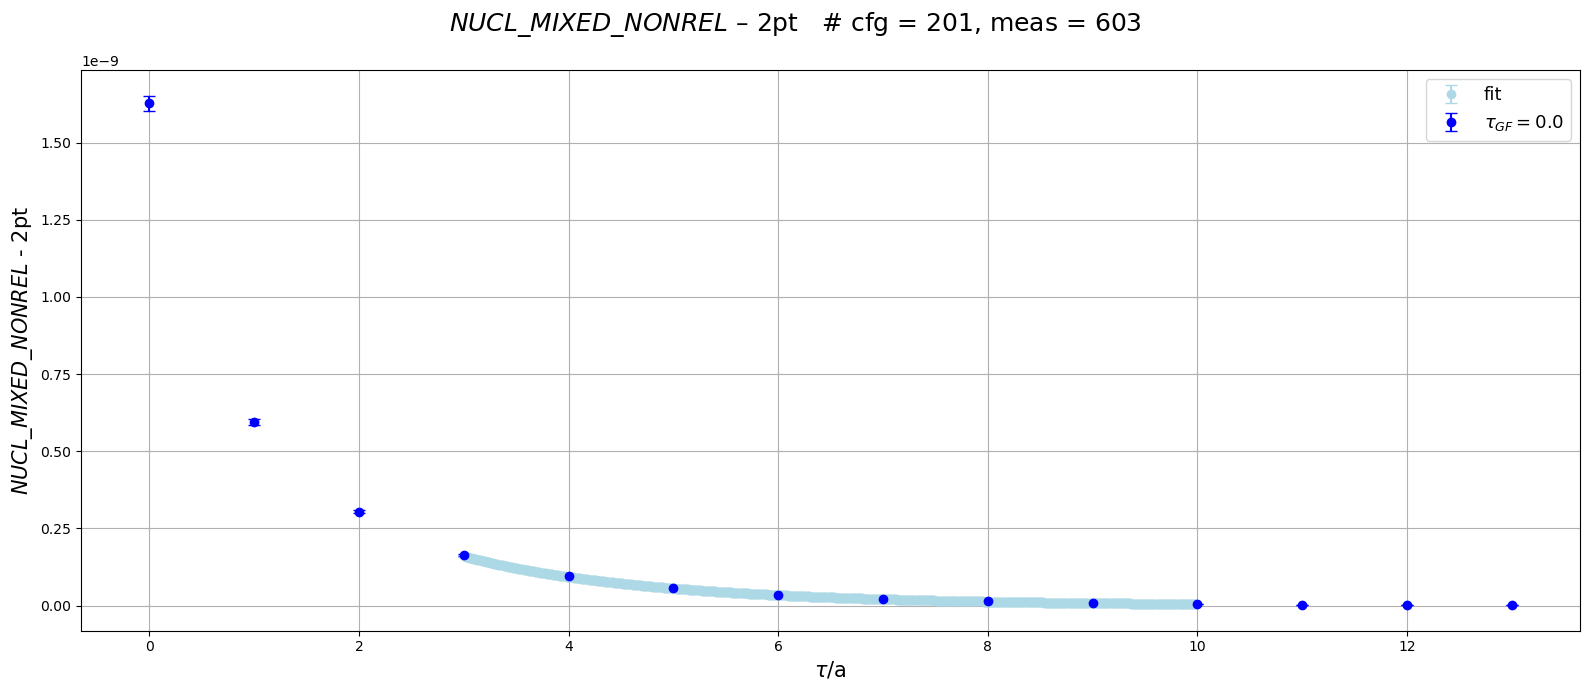

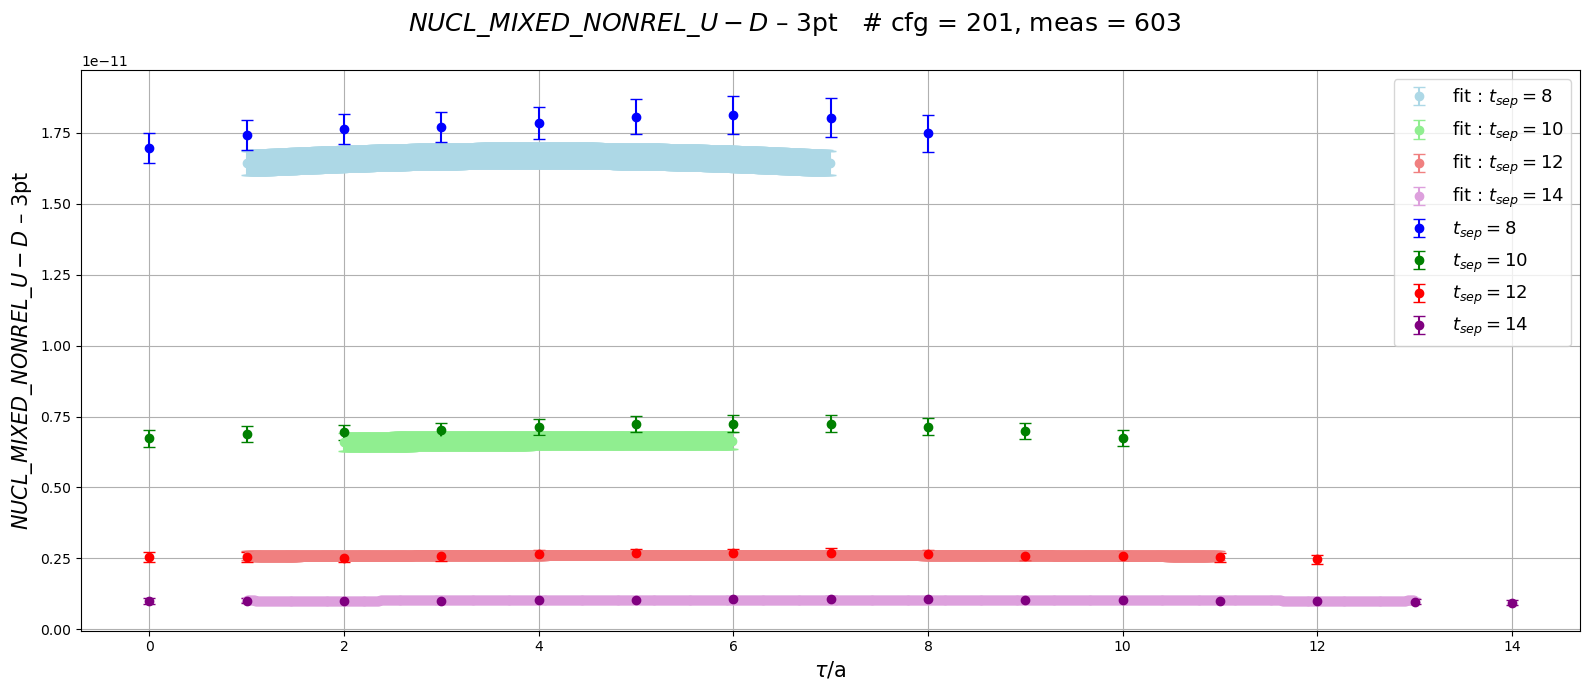

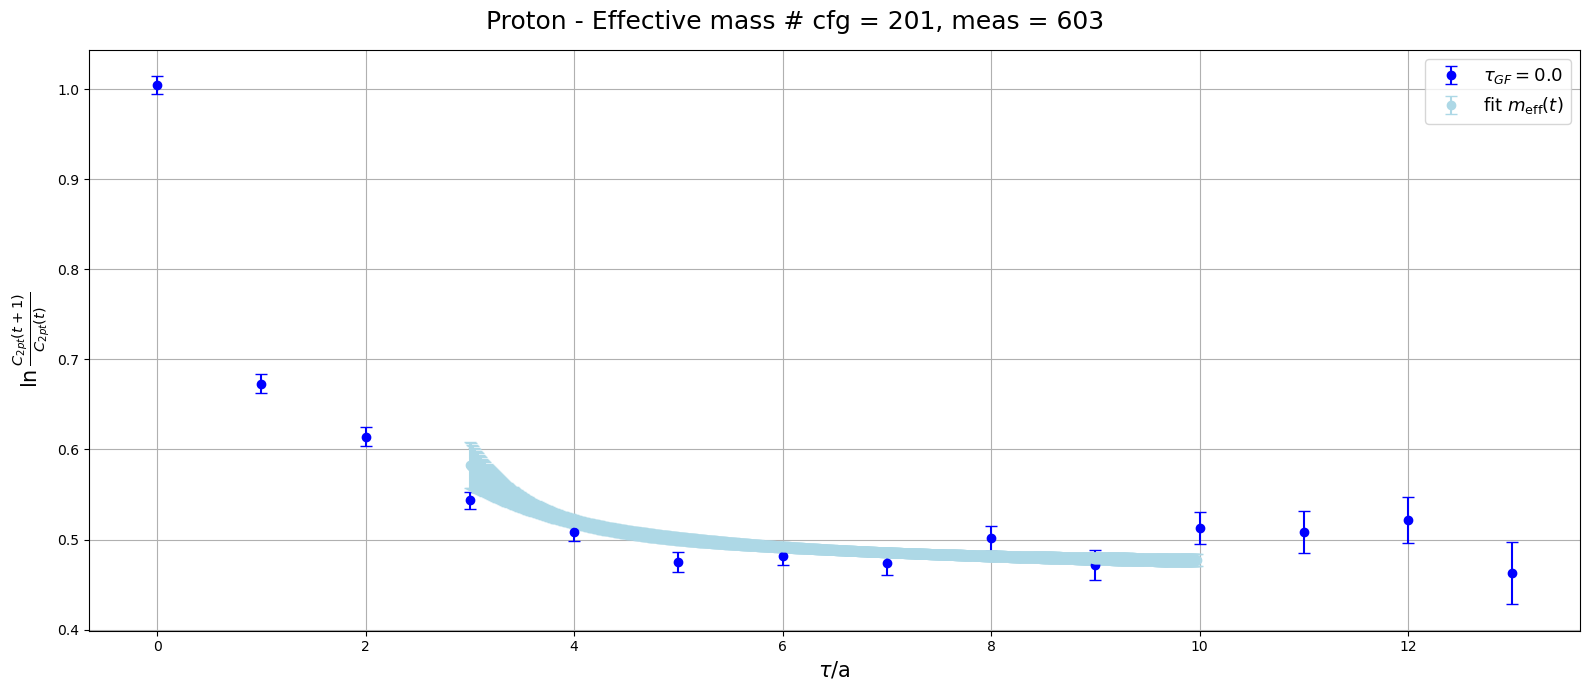

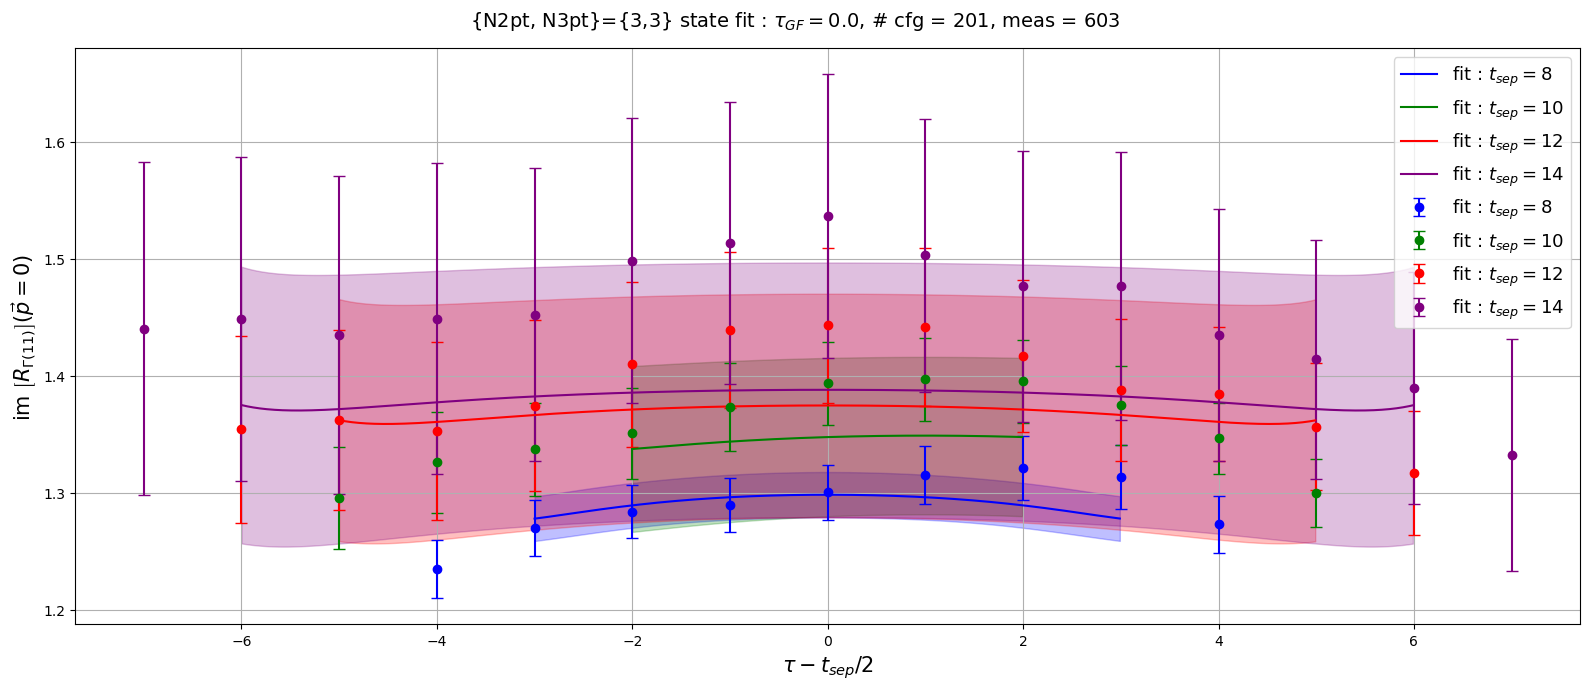

In [5]:
plot_all_flows(11, "im", cfglist, 3, 10, 1, 7, 2, 6, 1, 11, 1, 13)

{N2pt, N3pt}={3,3} state fit: 12 parameters

Flow tau =  0.0
Points included for fit:  39
DOF =  27
chi2dof 1.3509(6560) 

Akaike Information Criterion (AIC) = 60.474587865480586
Corrected AIC (AICc) = 68.68511418127007 

  M0 = 0.4798(0156) = 0.47981399994 ± 0.01563087997
  A0^2 = 6.15(144)e-10 = 0.00000000061 ± 0.00000000014
  M1 = 0.8515(0079) = 0.85149080588 ± 0.00787717801
  A1^2 = 6.91(10451)e-11 = 0.00000000007 ± 0.00000000105
 O00 = 1.1449(2146) = 1.14487264052 ± 0.21464971796
 O01 = 0.4099(17805) = 0.40992311663 ± 1.78046560419
 O11 = -0.2478(115672) = -0.24779658684 ± 11.56716586181
  M2 = 1.6385(52379) = 1.63846498851 ± 5.23789820575
  A2 = 4.23(2355)e-5 = 0.00004228593 ± 0.00023550869
 O02 = 0.1317(8295) = 0.13165489457 ± 0.82951389986
 O12 = -0.1653(50856) = -0.16530873489 ± 5.08560606756
 O22 = 0.0924(34457) = 0.09239206370 ± 3.44567606563
A1^2 / A0^2 = 6.88(92975)e5 = 687812.098083 ± 92975134.984921

 0.4798(0156) & 0.8515(0079) & 6.15(144)e-10 & 6.91(10451)e-11 & 6.88(9

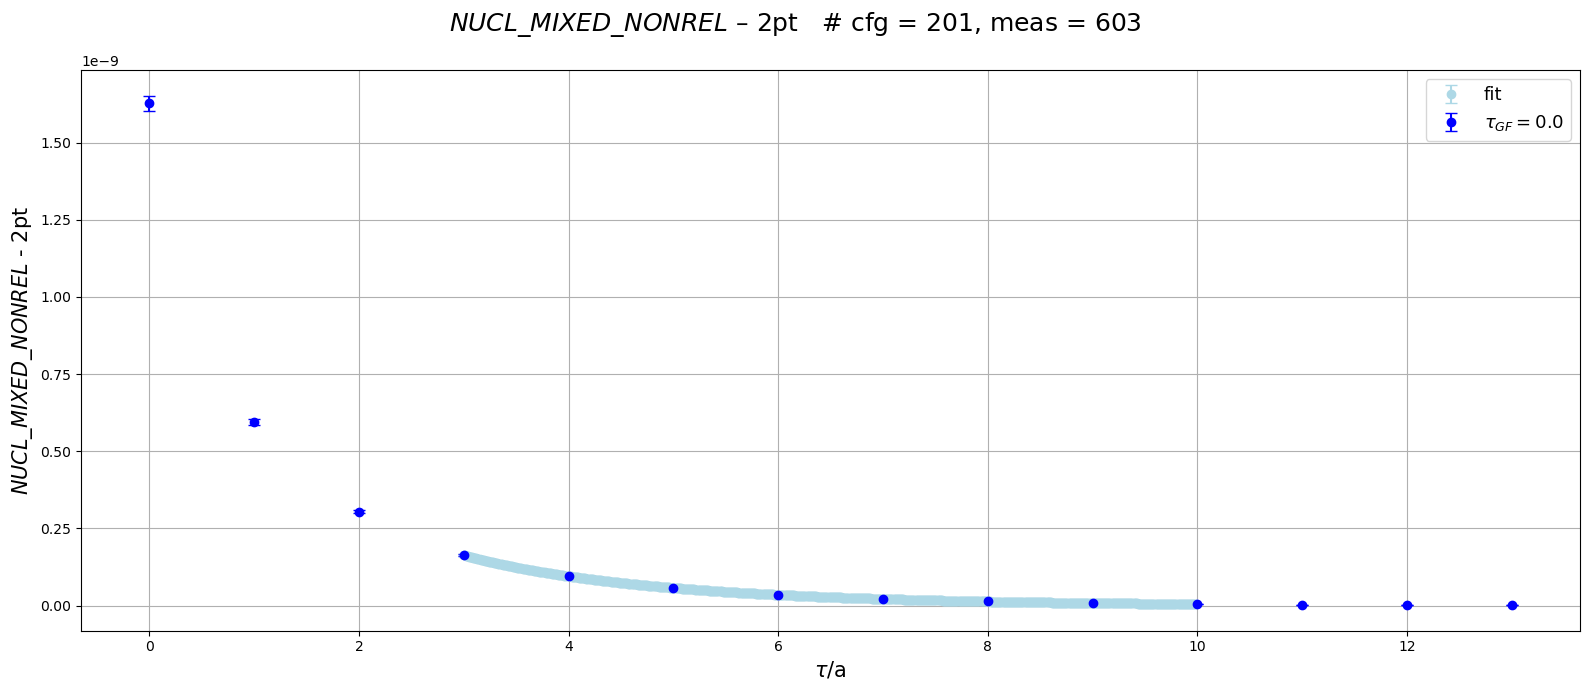

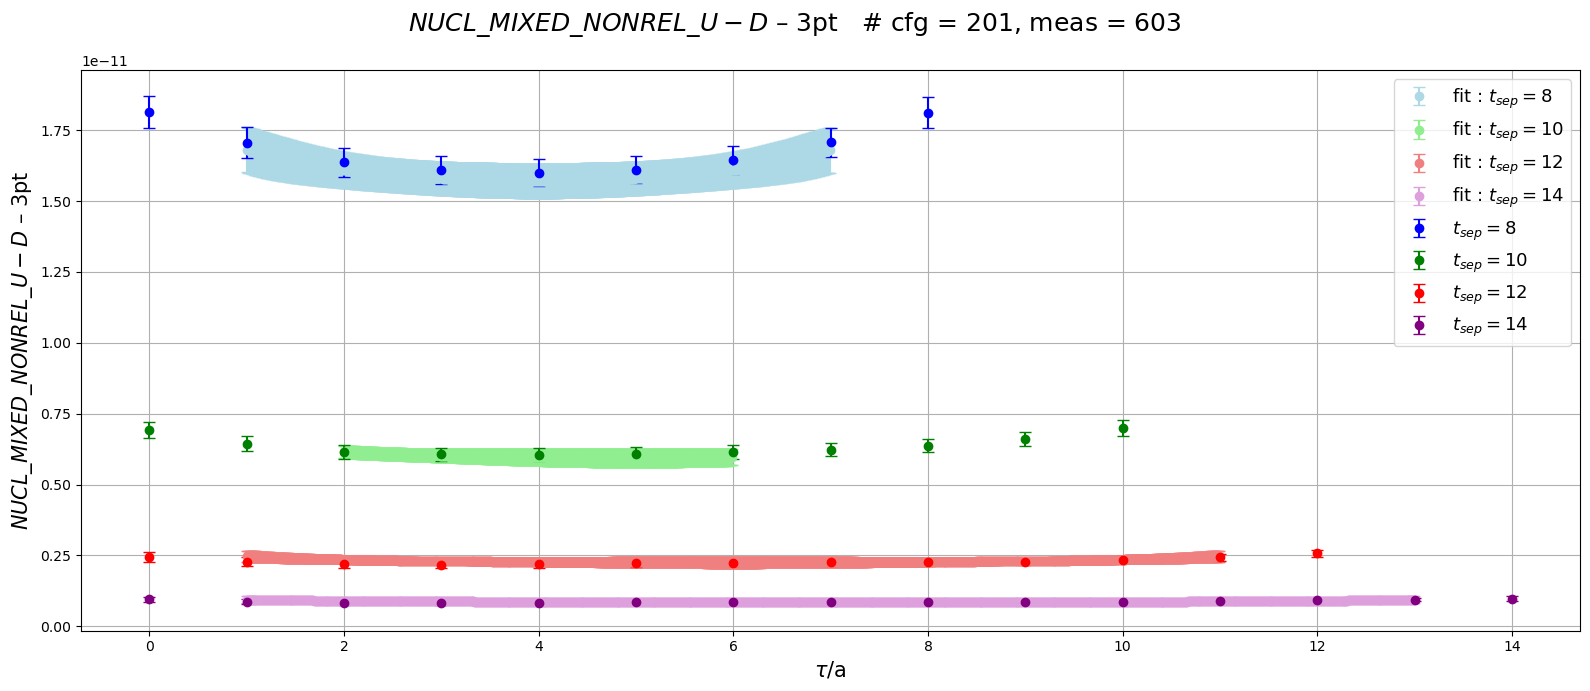

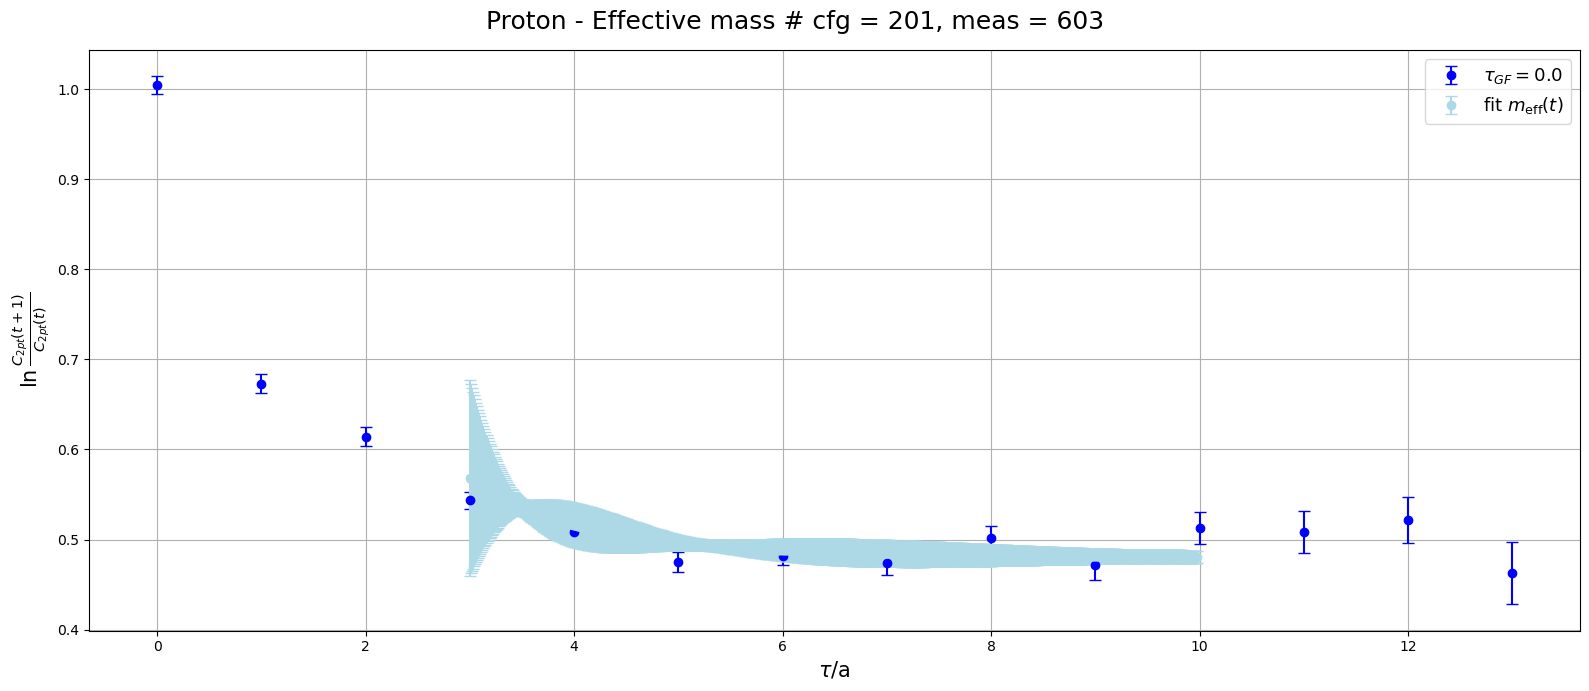

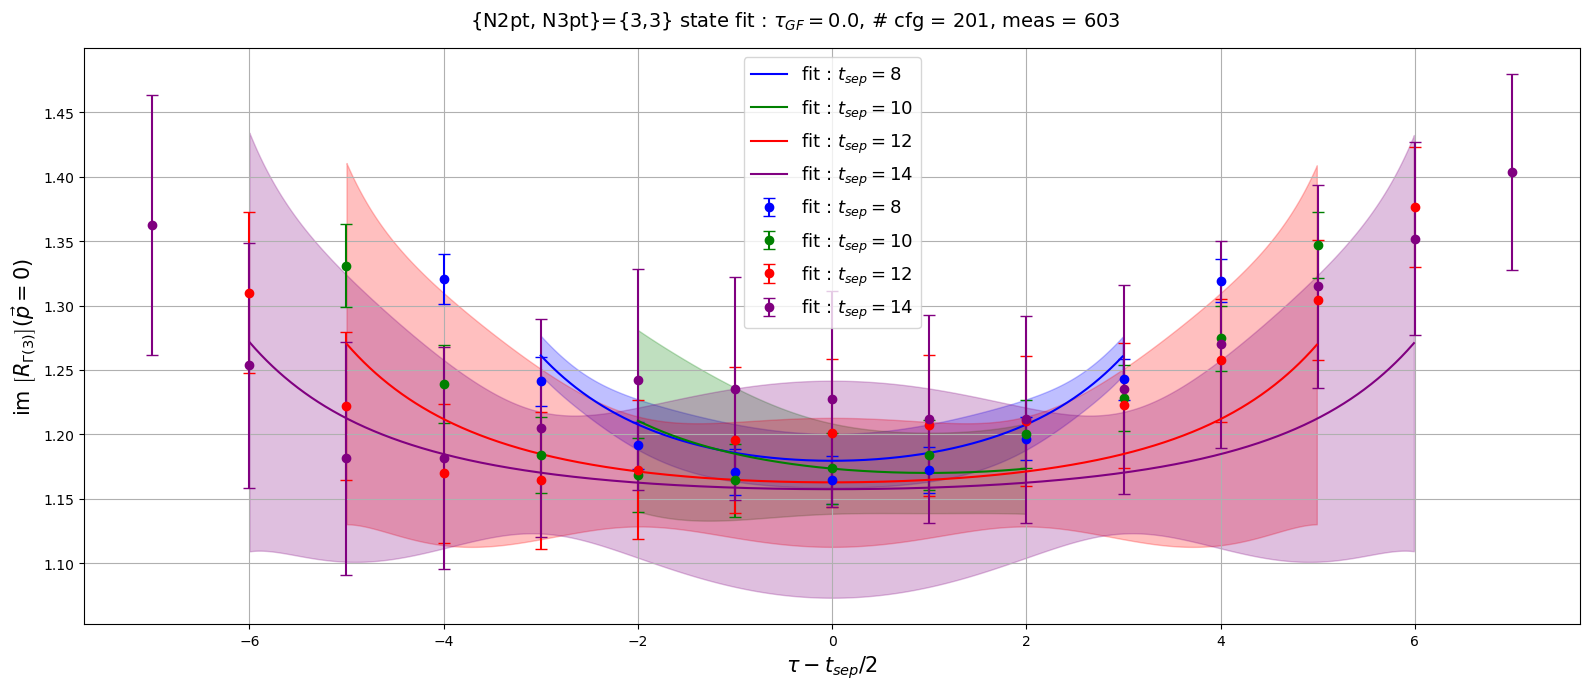

In [3]:
plot_all_flows(3, "im", cfglist, 3, 10, 1, 7, 2, 6, 1, 11, 1, 13)

{N2pt, N3pt}={3,3} state fit: 12 parameters

Flow tau =  0.0
Points included for fit:  39
DOF =  27
chi2dof 2.2043(6221) 

Akaike Information Criterion (AIC) = 83.51592431966438
Corrected AIC (AICc) = 91.72645063545386 

  M0 = 0.4772(0074) = 0.47718126335 ± 0.00735152509
  A0^2 = 5.94(42)e-10 = 0.00000000059 ± 0.00000000004
  M1 = 0.8501(0039) = 0.85006335635 ± 0.00387907578
  A1^2 = 1.77(144)e-10 = 0.00000000018 ± 0.00000000014
 O00 = 1.2801(0976) = 1.28012392026 ± 0.09764907388
 O01 = -0.0201(0147) = -0.02008233858 ± 0.01469824138
 O11 = -1.5131(61260) = -1.51313697549 ± 6.12595320942
  M2 = 2.1351(11730) = 2.13511589850 ± 1.17299565961
  A2 = 6.79(993)e-5 = 0.00006789155 ± 0.00009925878
 O02 = 0.0029(0063) = 0.00285198806 ± 0.00634091403
 O12 = 0.0317(1547) = 0.03171952961 ± 0.15466676216
 O22 = 0.3431(0475) = 0.34310317853 ± 0.04753518359
A1^2 / A0^2 = 3.3680(29748) = 3.368027 ± 2.974805

 0.4772(0074) & 0.8501(0039) & 5.94(42)e-10 & 1.77(144)e-10 & 3.3680(29748) & 2.2043(6221) & 

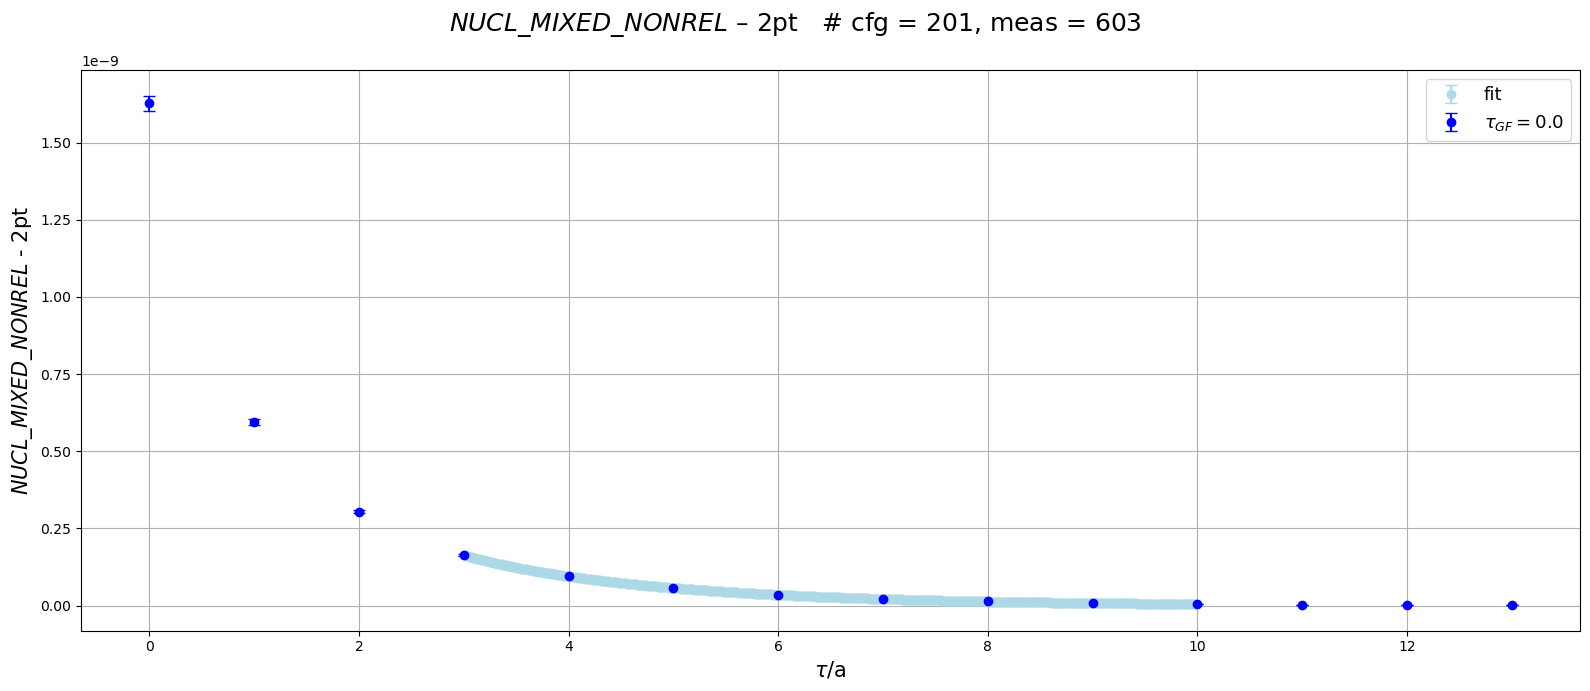

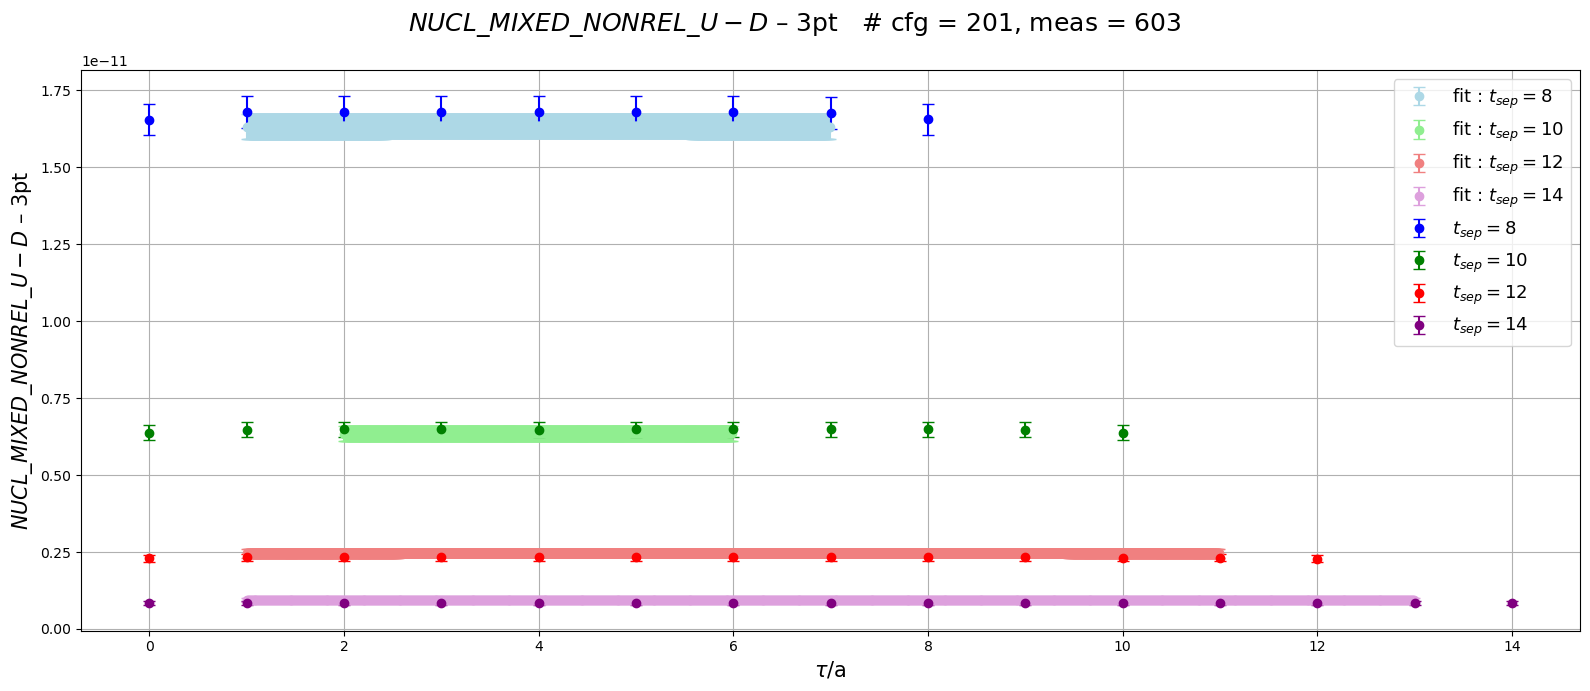

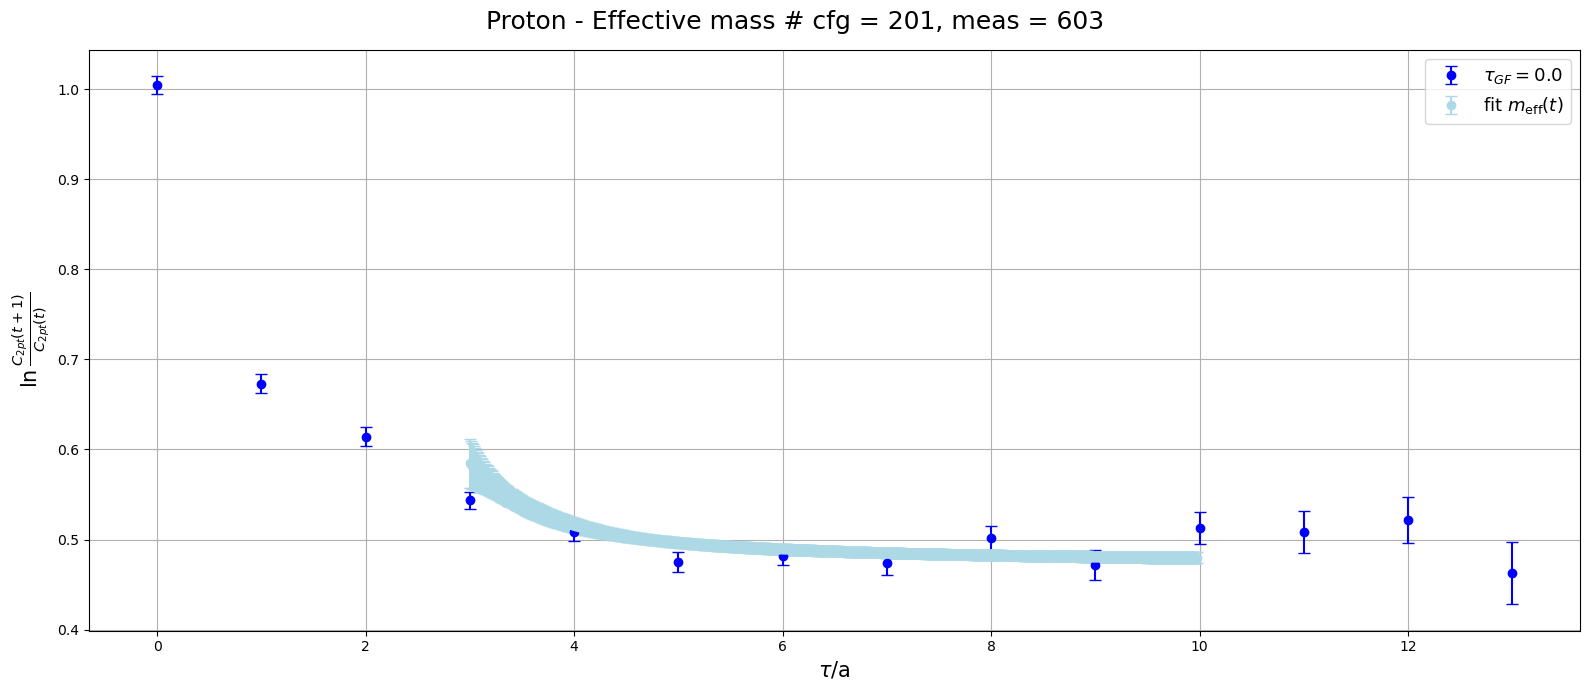

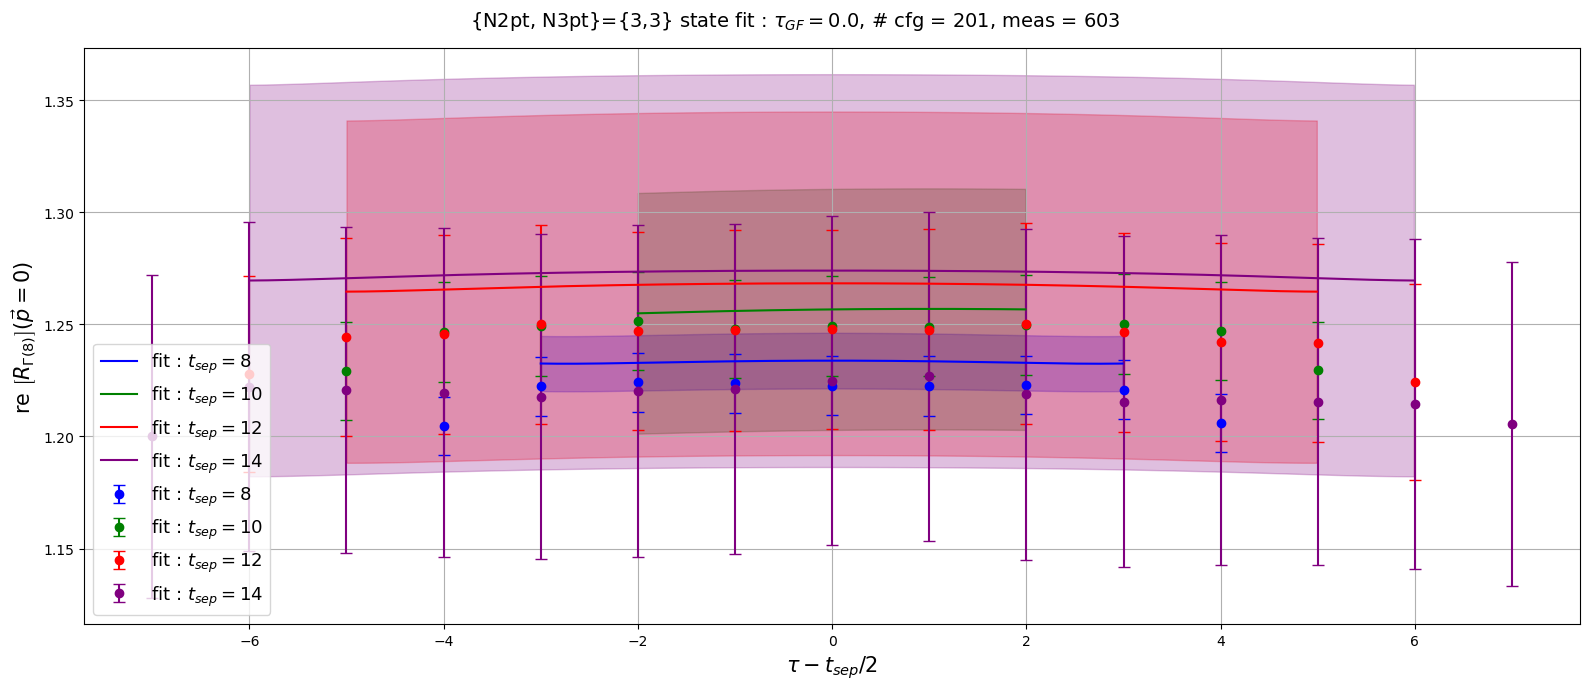

In [4]:
plot_all_flows(8, "re", cfglist, 3, 10, 1, 7, 2, 6, 1, 11, 1, 13)